# ****============ CUSTOMER SEGMENTATION =============****

En este cuaderno, exportaré datos e intentaré segmentar a los clientes en un mercado de Brasil utilizando el método de análisis RFM. El objetivo de este proyecto es ayudar al equipo de marketing a determinar su mercado objetivo para ser más específico. Dividiré este cuaderno en las siguientes etapas:

    Contexto
    Preprocesamiento de datos
    Modelado
    Conclusión

Este cuaderno no es demasiado profundo para discutir la teoría, pero daré razones por las cuales hice estos pasos. ¡Empecemos!
1. CONTEXTO

Este conjunto de datos es Olist, el mercado más grande de Brasil. Esta información se recopiló en el período 2016-2018. Olist conecta a pequeñas empresas de todo Brasil para ingresar a sus redes de manera muy sencilla simplemente mediante un contrato. Estos empresarios pueden vender sus productos a través de la plataforma Olist y enviarlos directamente a sus clientes con correos que han trabajado igual que Olist.

Después de que el cliente compre su producto a Olist, el vendedor recibirá una notificación para cumplir de inmediato con el pedido del cliente. Cuando un cliente recibe un producto, el cliente puede dar una calificación de satisfacción y comentarios relacionados con los servicios prestados por el vendedor a través del correo electrónico enviado.

Los datos recopilados están en 9 archivos diferentes, por lo que deben combinarse para obtener todos los datos en función de los parámetros que deseamos. A continuación se muestra un esquema de conexión entre los datos que se utilizarán como punto de referencia al fusionar datos.

![](https://i.imgur.com/HRhd2Y0.png)

In [1]:
#Importing Libraries
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Fetaure Selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#Modelling Algoritm
from sklearn.cluster import KMeans

#Model Evaluation
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
#Load All The Data
olist_orders = pd.read_csv('./olist_orders_dataset.csv')
olist_products = pd.read_csv('./olist_products_dataset.csv')
olist_items = pd.read_csv('./olist_order_items_dataset.csv')
olist_customers = pd.read_csv('./olist_customers_dataset.csv')
olist_payments = pd.read_csv('./olist_order_payments_dataset.csv')
olist_sellers = pd.read_csv('./olist_sellers_dataset.csv')
olist_geolocation = pd.read_csv('./olist_geolocation_dataset.csv')
olist_reviews = pd.read_csv('./olist_order_reviews_dataset.csv')
olist_product_category_name = pd.read_csv('./product_category_name_translation.csv')

In [3]:
olist_product_category_name.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [4]:
all_data = olist_orders.merge(olist_items, on='order_id', how='left')
all_data = all_data.merge(olist_payments, on='order_id', how='inner')
all_data = all_data.merge(olist_reviews, on='order_id', how='inner')
all_data = all_data.merge(olist_products, on='product_id', how='inner')
all_data = all_data.merge(olist_customers, on='customer_id', how='inner')
all_data = all_data.merge(olist_sellers, on='seller_id', how='inner')
all_data = all_data.merge(olist_product_category_name,on='product_category_name',how='inner')
#all_data = all_data.merge(olist_geolocation, on='seller_zip_code_prefix', how='inner')

In [5]:
#Vea qué porcentaje de datos está en blanco en cada columna
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.04
order_delivered_customer_date     2.16
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.99
review_comment_message           57.22
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [6]:
# Viendo la información en los datos tanto el número de columnas, como la entrada a la memoria
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116581 entries, 0 to 116580
Data columns (total 40 columns):
order_id                         116581 non-null object
customer_id                      116581 non-null object
order_status                     116581 non-null object
order_purchase_timestamp         116581 non-null object
order_approved_at                116567 non-null object
order_delivered_carrier_date     115368 non-null object
order_delivered_customer_date    114066 non-null object
order_estimated_delivery_date    116581 non-null object
order_item_id                    116581 non-null float64
product_id                       116581 non-null object
seller_id                        116581 non-null object
shipping_limit_date              116581 non-null object
price                            116581 non-null float64
freight_value                    116581 non-null float64
payment_sequential               116581 non-null int64
payment_type                     116581 non-nul

# ** 2. PREPROCESAMIENTO DE DATOS **

En esta etapa, dejaremos los datos fuera del ruido / ruido (entradas en blanco, valores atípicos, etc.) para que los datos que se ingresen en el modelo estén limpios y listos para el modelado.

## ** 2.1 Manejo variable **

Esta etapa tiene como objetivo ajustar los tipos de datos en función de su entrada y también eliminar la duplicación de los datos que tenemos



In [7]:
all_data['order_purchase_timestamp'].dtype

dtype('O')

In [8]:
# Cambie el tipo de datos en la columna de fecha para que el tipo de datos finalice
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'] 
for col in date_columns:
    all_data[col] = pd.to_datetime(all_data[col], format='%Y-%m-%d %H:%M:%S')

In [9]:
# Ver si hay datos duplicados
print('Duplicados: ',all_data.duplicated().sum())

Duplicados:  0


In [10]:
#Cree una columna de mes_orden para la exploración de datos
all_data['Month_order'] = all_data['order_purchase_timestamp'].dt.to_period('M').astype('str')

In [11]:
all_data[['Month_order','order_purchase_timestamp']].head()

,Month_order,order_purchase_timestamp
0,2017-10,2017-10-02 10:56:33
1,2017-10,2017-10-02 10:56:33
2,2017-10,2017-10-02 10:56:33
3,2017-08,2017-08-15 18:29:31
4,2017-08,2017-08-02 18:24:47


In [12]:
# Elija entradas que van desde 01-2017 hasta 08-2018
#Porque hay datos que están fuera de balance con el promedio de cada mes en los datos antes del 01-2017 y después del 08-2018
# basado en datos de compra / order_purchase_timestamp
start_date = "2017-01-01"
end_date = "2018-08-31"

after_start_date = all_data['order_purchase_timestamp'] >= start_date
before_end_date = all_data['order_purchase_timestamp'] <= end_date
between_two_dates = after_start_date & before_end_date
all_data = all_data.loc[between_two_dates]

## 2.2 Manejo de valores perdidos

En esta etapa, se hace para eliminar entradas vacías mediante el uso de otras características o el uso de estadísticas (media / mediana)

In [13]:
# Vea qué porcentaje de datos está en blanco en cada columna
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.01
order_delivered_customer_date     2.12
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.95
review_comment_message           57.33
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [14]:
# Gestiona entradas vacías en la columna order_approved_at
missing_1 = all_data['order_approved_at'] - all_data['order_purchase_timestamp']
print(missing_1.describe())
print('='*50)
print('Mediana desde el momento en que se aprobó la orden: ',missing_1.median())

# tomamos la mediana porque hay quienes aprueban directamente desde el momento en que ordena, algunos son de hasta 60 días
add_1 = all_data[all_data['order_approved_at'].isnull()]['order_purchase_timestamp'] + missing_1.median()
all_data['order_approved_at']= all_data['order_approved_at'].replace(np.nan, add_1)

count                    116178
mean     0 days 10:27:08.897923
std      0 days 21:53:11.220121
min             0 days 00:00:00
25%             0 days 00:12:56
50%             0 days 00:20:46
75%      0 days 14:54:27.750000
max            60 days 10:51:59
dtype: object
Mediana desde el momento en que se aprobó la orden:  0 days 00:20:46


In [15]:
# Gestiona entradas vacías en la columna order_approved_at
all_data[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
3,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43
4,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01


In [16]:
# Gestión de entradas vacías en la columna order_delivered_carrier_date
missing_2 = all_data['order_delivered_carrier_date'] - all_data['order_approved_at']
print(missing_2.describe())
print('='*50)
print('Mediana desde el momento de la solicitud hasta el envío: ',missing_2.median())

# Tomamos la mediana porque algunos barcos están dentro de las 21 horas del tiempo acordado, algunos hasta 107 días
add_2 = all_data[all_data['order_delivered_carrier_date'].isnull()]['order_approved_at'] + missing_2.median()
all_data['order_delivered_carrier_date']= all_data['order_delivered_carrier_date'].replace(np.nan, add_2)

count                    115016
mean     2 days 19:36:08.343613
std      3 days 11:05:42.705027
min         -172 days +18:44:38
25%             0 days 21:12:37
50%      1 days 20:05:56.500000
75%      3 days 14:45:47.750000
max           107 days 01:16:38
dtype: object
Mediana desde el momento de la solicitud hasta el envío:  1 days 20:05:56.500000


In [17]:
# Gestión de entradas vacías en la columna order_delivered_customer_date
missing_3 = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']
print(missing_3.describe())
print('='*50)
print('Mediana desde el momento en que se envió hasta que el cliente la recibió: ',missing_3.median())

# tomamos la mediana porque hay un tiempo de entrega de -17 días, lo que significa que es atípico, también hay un tiempo de entrega de hasta 205 días
add_3 = all_data[all_data['order_delivered_customer_date'].isnull()]['order_delivered_carrier_date'] + missing_3.median()
all_data['order_delivered_customer_date']= all_data['order_delivered_customer_date'].replace(np.nan, add_3)

count                     113726
mean      9 days 05:09:53.148923
std       8 days 15:22:27.173498
min           -17 days +21:41:31
25%              4 days 01:44:35
50%              7 days 01:35:06
75%      11 days 22:31:48.500000
max            205 days 04:35:00
dtype: object
Mediana desde el momento en que se envió hasta que el cliente la recibió:  7 days 01:35:06


In [18]:
# Manejar las columnas review_comment_title y review_comment_message
#Porque el número de entradas en blanco es muy grande e imposible de completar porque no hay variables que puedan
# usado para calcularlo. Porque este es el comentario y el título del comentario
# Luego eliminaremos la columna

all_data = all_data.drop(['review_comment_title', 'review_comment_message'], axis=1)

In [19]:
round((all_data.isna().sum()/ len(all_data)*100),3)

order_id                         0.000
customer_id                      0.000
order_status                     0.000
order_purchase_timestamp         0.000
order_approved_at                0.000
order_delivered_carrier_date     0.000
order_delivered_customer_date    0.000
order_estimated_delivery_date    0.000
order_item_id                    0.000
product_id                       0.000
seller_id                        0.000
shipping_limit_date              0.000
price                            0.000
freight_value                    0.000
payment_sequential               0.000
payment_type                     0.000
payment_installments             0.000
payment_value                    0.000
review_id                        0.000
review_score                     0.000
review_creation_date             0.000
review_answer_timestamp          0.000
product_category_name            0.000
product_name_lenght              0.000
product_description_lenght       0.000
product_photos_qty       

In [20]:
# Entrega de entrada vacía en las columnas product_weight_g, product_length_cm, product_height_cm, product_width_cm
#Porque solo hay 1, entonces lo dejamos caer
all_data = all_data.dropna()

In [21]:
# Compruebe si hay entradas en blanco
round((all_data.isnull().sum()/len(all_data)*100),4)

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
review_id                        0.0
review_score                     0.0
review_creation_date             0.0
review_answer_timestamp          0.0
product_category_name            0.0
product_name_lenght              0.0
product_description_lenght       0.0
product_photos_qty               0.0
product_weight_g                 0.0
p

In [22]:
all_data[['order_item_id','product_name_lenght', 
          'product_description_lenght', 'product_photos_qty' ]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116191 entries, 0 to 116580
Data columns (total 4 columns):
order_item_id                 116191 non-null float64
product_name_lenght           116191 non-null float64
product_description_lenght    116191 non-null float64
product_photos_qty            116191 non-null float64
dtypes: float64(4)
memory usage: 4.4 MB


In [23]:
# Ajuste el tipo de datos con los datos de entrada
all_data = all_data.astype({'order_item_id': 'int64', 
                            'product_name_lenght': 'int64',
                            'product_description_lenght':'int64', 
                            'product_photos_qty':'int64'})

## ** 2.3. Extracción de características **

En esta etapa, la adición de nuevas columnas que contienen cálculos de varias columnas para obtener una nueva característica



In [24]:
#Cree una columna order_process_time para ver cuánto tiempo llevará iniciar el pedido hasta
# artículos son aceptados por los clientes
all_data['order_process_time'] = all_data['order_delivered_customer_date'] - all_data['order_purchase_timestamp']

In [25]:
#Cree una columna order_delivery_time para ver cuánto tiempo se requiere el tiempo de envío para cada pedido
all_data['order_delivery_time'] = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']

In [26]:
#Cree una columna order_time_accuracy para ver si desde el tiempo estimado hasta que algo sea apropiado o tarde
# Si el valor es + positivo, entonces es más rápido hasta que, si es 0, está justo a tiempo, pero si es negativo, llega tarde
all_data['order_accuracy_time'] = all_data['order_estimated_delivery_date'] - all_data['order_delivered_customer_date'] 

In [27]:
#Cree una columna order_approved_time para ver cuánto tiempo tomará desde el pedido hasta la aprobación
all_data['order_approved_time'] = all_data['order_approved_at'] - all_data['order_purchase_timestamp'] 

In [28]:
#Cree una columna review_send_time para averiguar cuánto tiempo se envió la encuesta de satisfacción después de recibir el artículo.
all_data['review_send_time'] = all_data['review_creation_date'] - all_data['order_delivered_customer_date']

In [29]:
#Cree una columna review_answer_time para averiguar cuánto tiempo llevará completar una revisión después de
# envió una encuesta de satisfacción del cliente.
all_data['review_answer_time'] = all_data['review_answer_timestamp'] - all_data['review_creation_date']

In [30]:
# Combine las columnas product_length_cm, product_height_cm y product_width_cm para convertirlo en un volumen
# con una nueva columna, volumen_producto
all_data['product_volume'] = all_data['product_length_cm'] * all_data['product_height_cm'] * all_data['product_width_cm']

In [31]:
all_data['product_volume'].nunique()

4470

In [32]:
all_data['order_process_time'].mean()

Timedelta('12 days 09:53:11.580178')

## ** 2.4 Exploración de datos **

Esta etapa se lleva a cabo la exploración de datos para obtener información o información que puede ser útil para la empresa.

Text(0, 0.5, 'Product category')

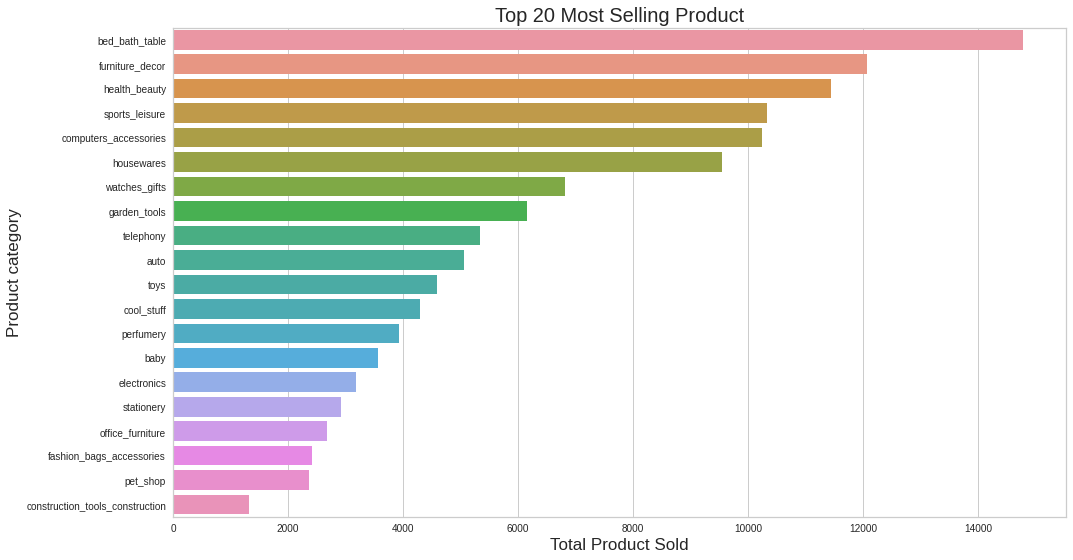

In [33]:
# ¿Qué productos tienen más demanda?
top_20_product_best_seller = all_data['order_item_id'].groupby(all_data['product_category_name_english']).sum().sort_values(ascending=False)[:20]
#print(top_20_product_best_seller)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values)
plt.title('Top 20 Most Selling Product',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Product category',fontsize=17)

Text(0, 0.5, 'City')

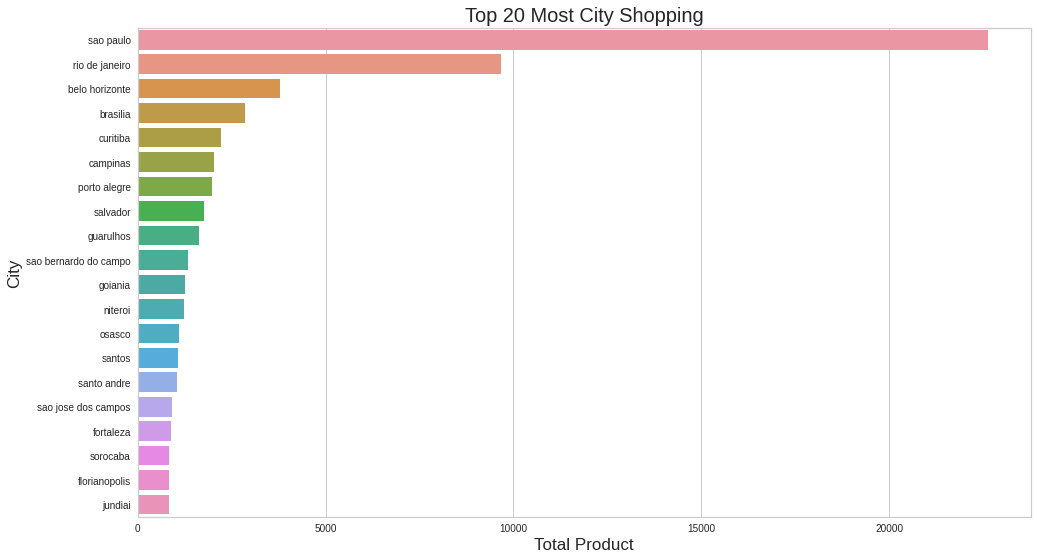

In [34]:
top_20_city_shopping = all_data['order_item_id'].groupby(all_data['customer_city']).sum().sort_values(ascending=False)[:20]
#print(top_20_city_shopping)

# ¿Qué ciudad compra más?
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_shopping.index,x=top_20_city_shopping.values)
plt.title('Top 20 Most City Shopping',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('City',fontsize=17)

Text(0, 0.5, 'Customer ID')

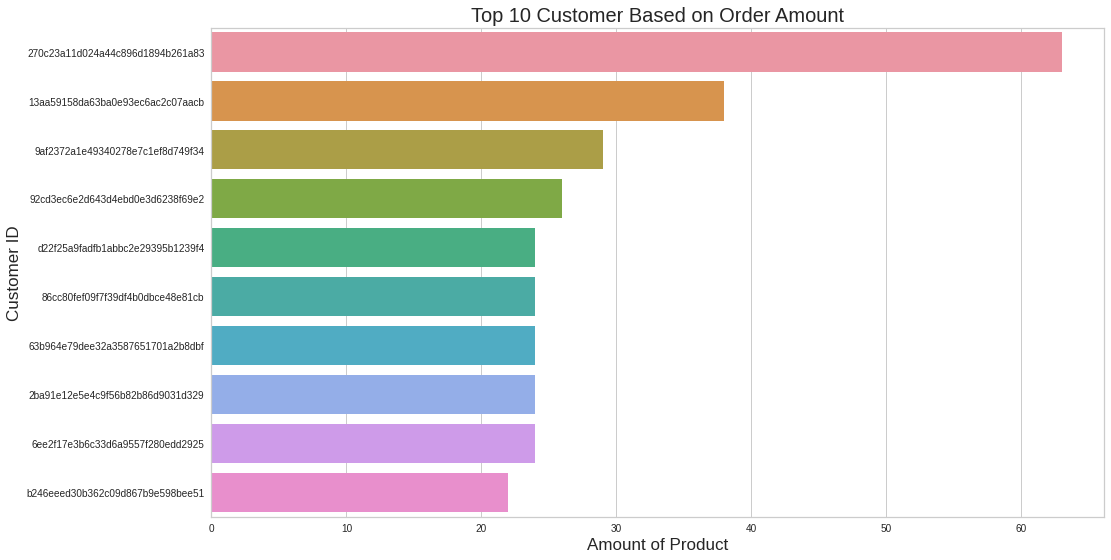

In [35]:
# ¿Quién es el mayor número de compras de clientes en función de la cantidad de pedidos?
top_10_customer_shopping = all_data['order_item_id'].groupby(all_data['customer_id']).count().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customer Based on Order Amount',fontsize=20)
plt.xlabel('Amount of Product',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

Text(0, 0.5, 'Customer ID')

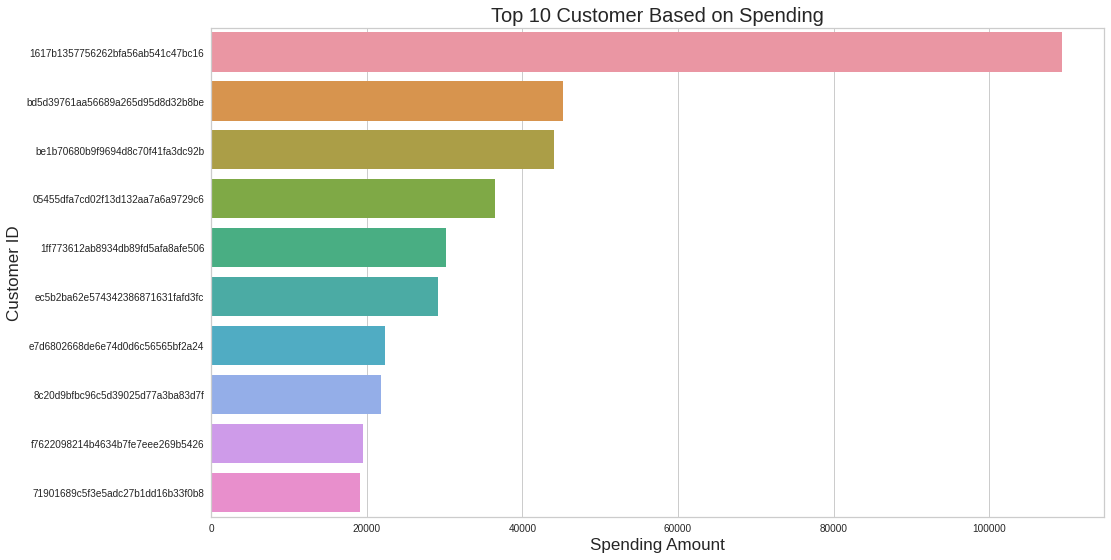

In [36]:
# ¿Quién es el cliente con más gasto en compras por precio?
top_10_customer_shopping = all_data['payment_value'].groupby(all_data['customer_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customer Based on Spending',fontsize=20)
plt.xlabel('Spending Amount',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

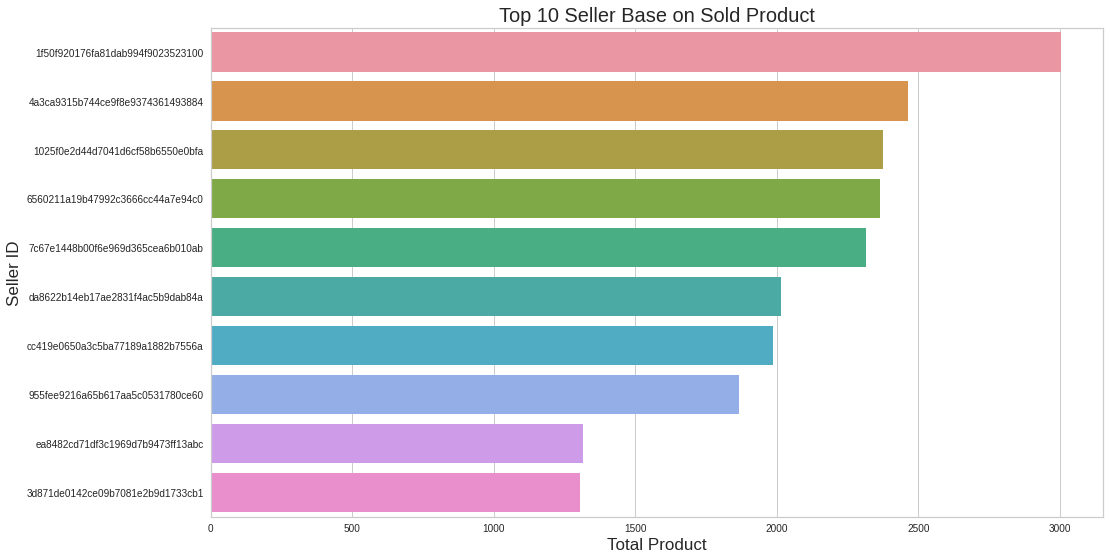

In [37]:
# ¿Qué vendedores venden más?
top_10_seller_order = all_data['order_item_id'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 Seller Base on Sold Product',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

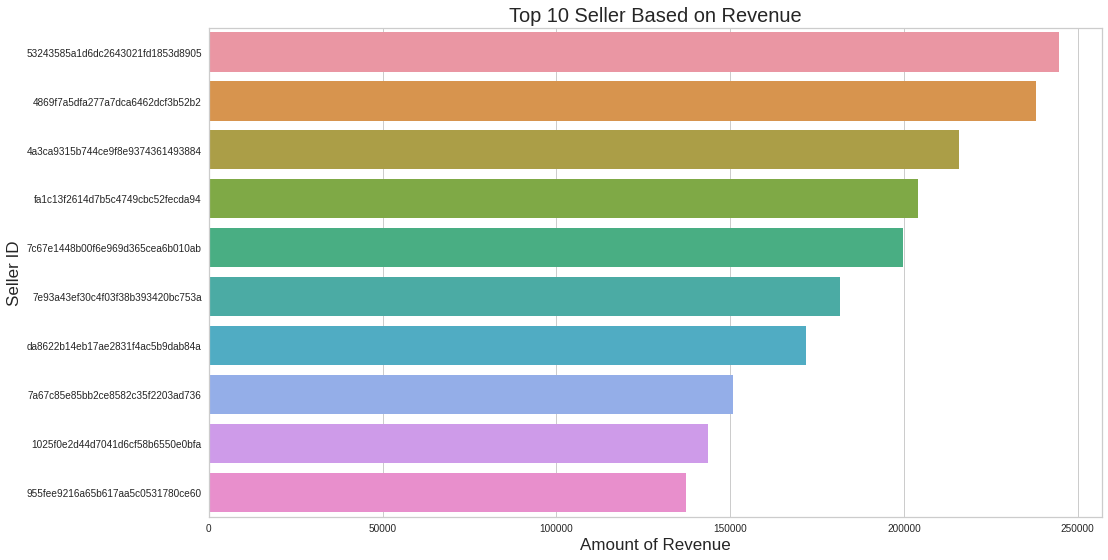

In [38]:
# Vendedor, ¿cuál es el mayor ingreso basado en ingresos?
top_10_seller_order = all_data['price'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 Seller Based on Revenue',fontsize=20)
plt.xlabel('Amount of Revenue',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

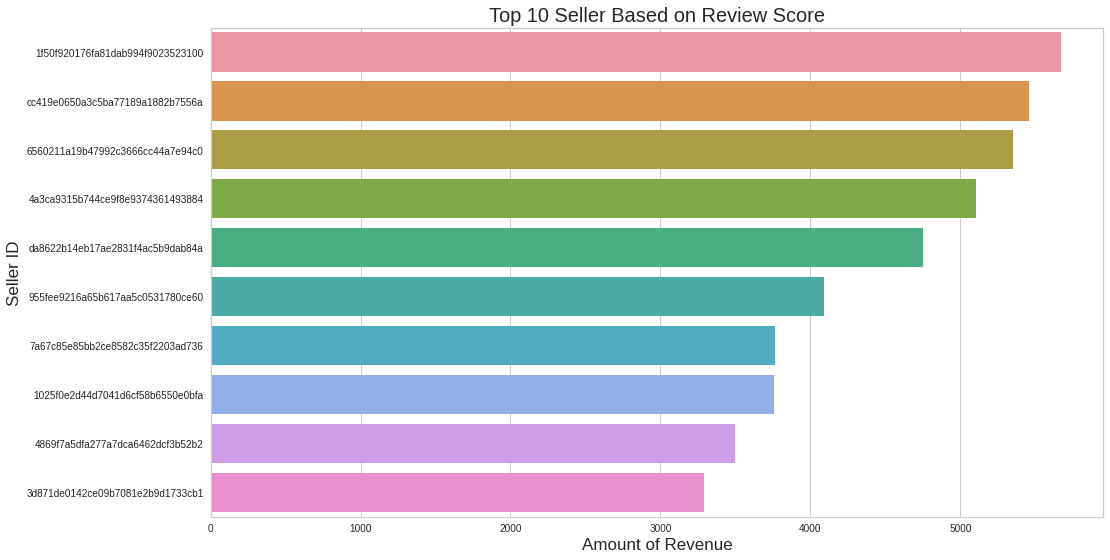

In [39]:
# Vendedor, ¿cuál es el mayor ingreso basado en ingresos?
top_10_seller_order = all_data[all_data['review_score'] == 5].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score)
plt.title('Top 10 Seller Based on Review Score',fontsize=20)
plt.xlabel('Amount of Revenue',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

In [40]:
# Distribución del estado del pedido del cliente
round(all_data.order_status.value_counts() / len(all_data),2)

delivered     0.98
shipped       0.01
canceled      0.00
processing    0.00
invoiced      0.00
approved      0.00
Name: order_status, dtype: float64

Text(0, 0.5, 'Time (Day)')

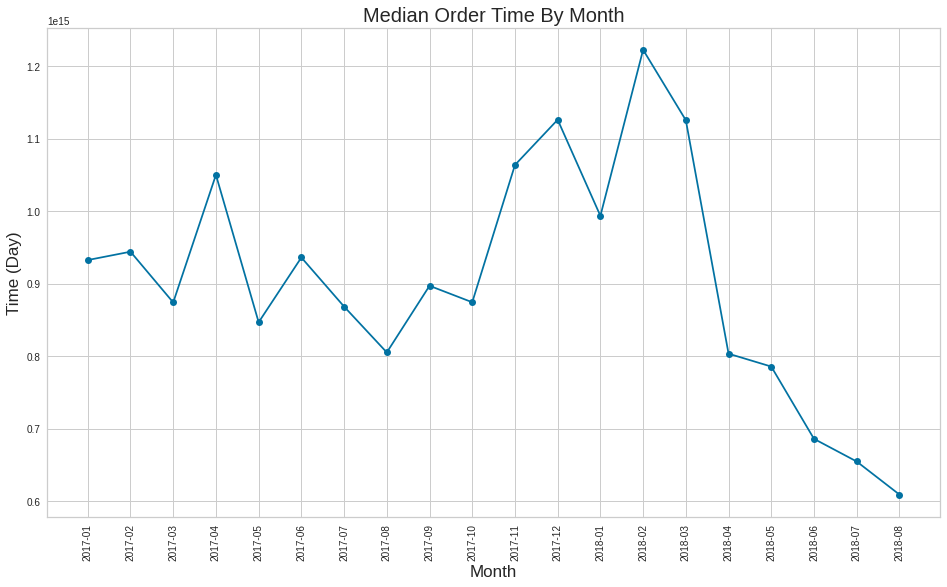

In [41]:
# ¿Cuál es el tiempo promedio desde el pedido hasta el recibo que se necesita en cada pedido mensual?
order_time_by_month = all_data['order_process_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(order_time_by_month.index, order_time_by_month.values, marker='o')
plt.title('Median Order Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Day)')

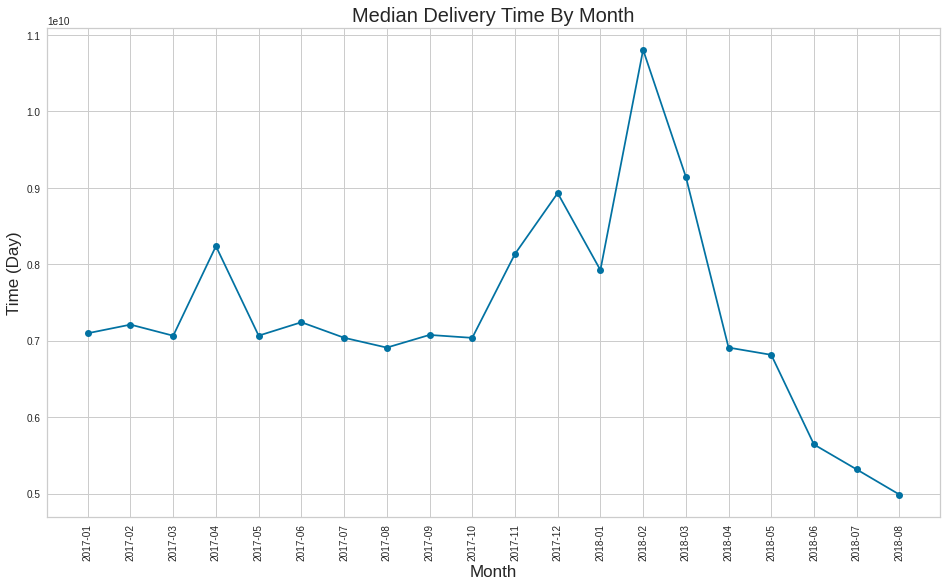

In [42]:
# ¿Cuál es el tiempo de entrega promedio requerido para cada primer pedido?
delivery_time_by_month = all_data['order_delivery_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta


fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o')
plt.title('Median Delivery Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Day)')

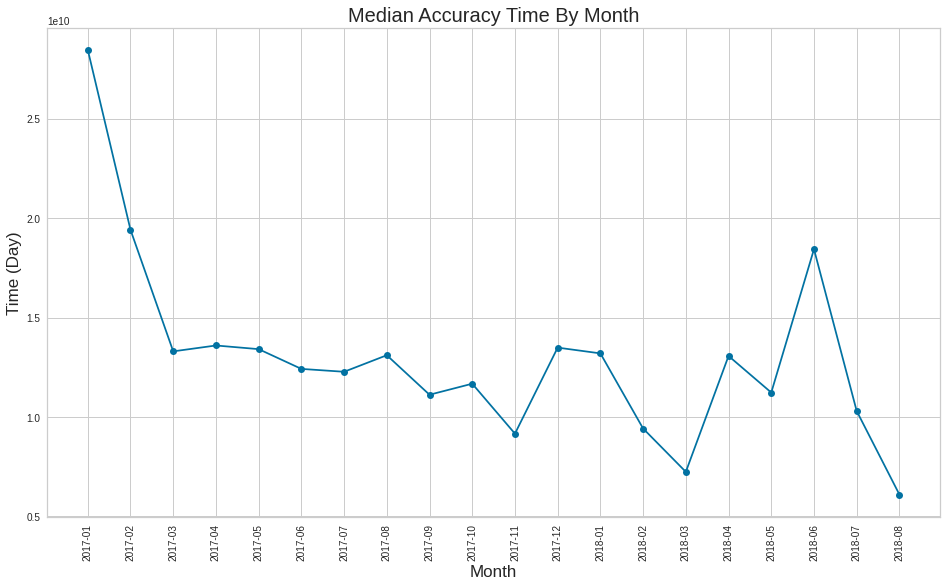

In [43]:
# ¿Cuál es la precisión media del tiempo de los envíos estimados y hasta el cliente en cada pedido mensual?
accuracy_time_by_month = all_data['order_accuracy_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(accuracy_time_by_month.index, accuracy_time_by_month.values / 86400, marker='o')
plt.title('Median Accuracy Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Minutes)')

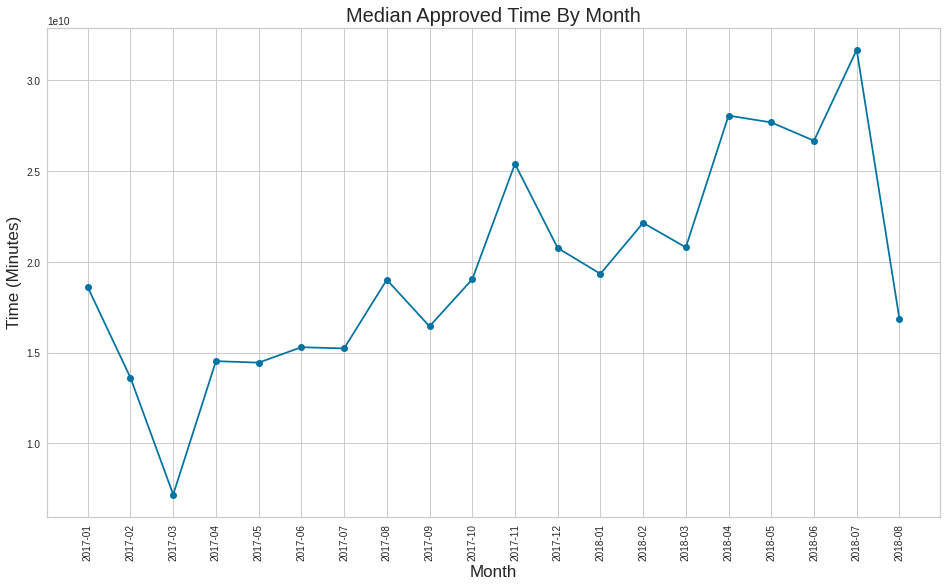

In [44]:
# ¿Cuál es el período de tiempo promedio hasta que se aprueba desde el momento del pedido en cada pedido mensual?
approved_time_by_month = all_data['order_approved_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(approved_time_by_month.index, approved_time_by_month.values / 60, marker='o')
plt.title('Median Approved Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Minutes)',fontsize=17)

Text(0, 0.5, 'Product Category')

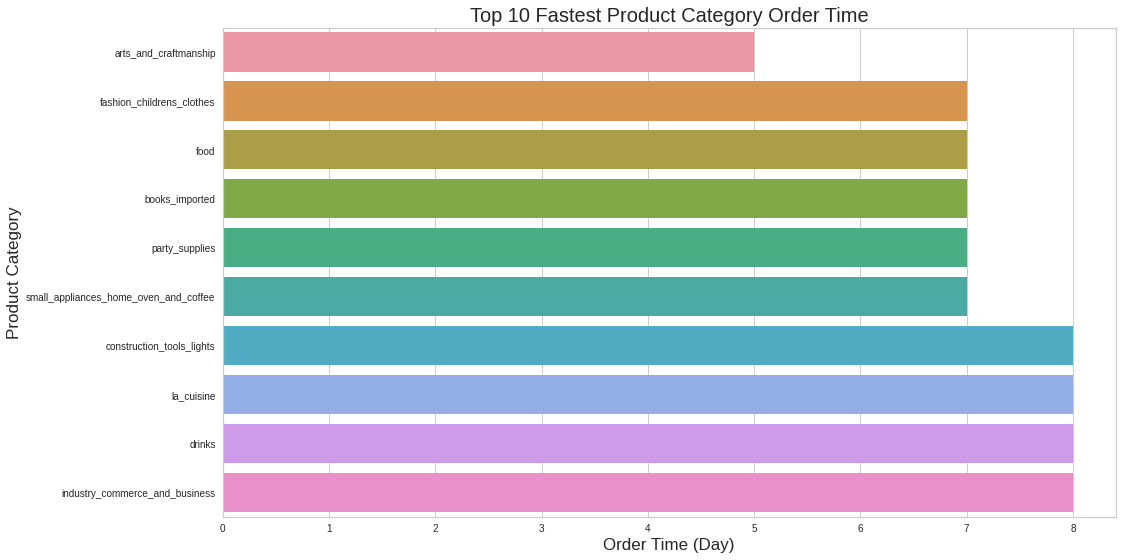

In [45]:
# 10 categorías de productos con el tiempo más rápido desde el pedido hasta la aceptación del cliente
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=True)[:10])

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 Fastest Product Category Order Time',fontsize=20)
plt.xlabel('Order Time (Day)',fontsize=17)
plt.ylabel('Product Category',fontsize=17)

Text(0, 0.5, 'Product Category')

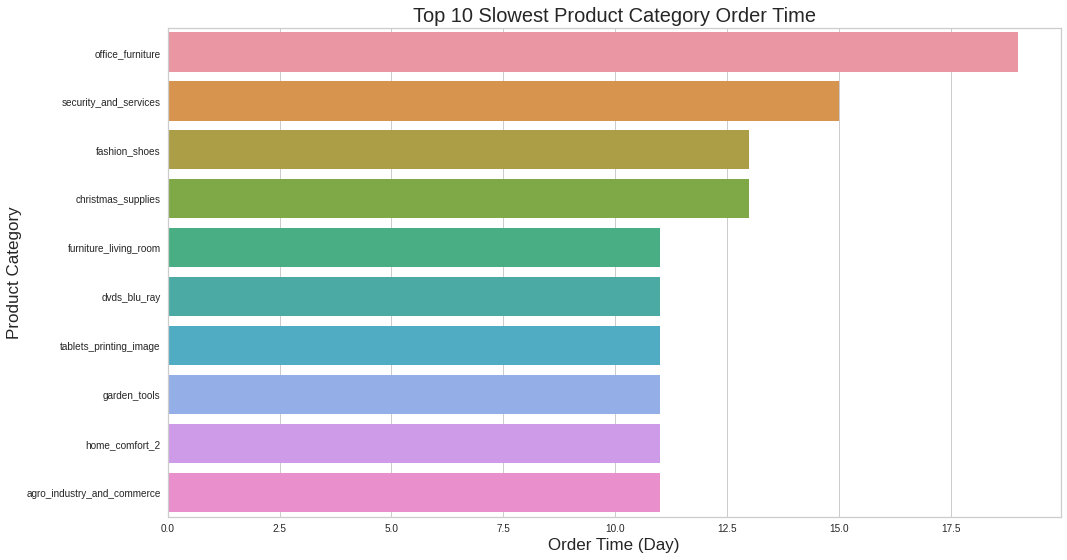

In [46]:
# 10 categorías de productos con el mayor tiempo desde el pedido hasta la aceptación del cliente
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=False)[:10])

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 Slowest Product Category Order Time',fontsize=20)
plt.xlabel('Order Time (Day)',fontsize=17)
plt.ylabel('Product Category',fontsize=17)

Text(0, 0.5, 'Amount Order')

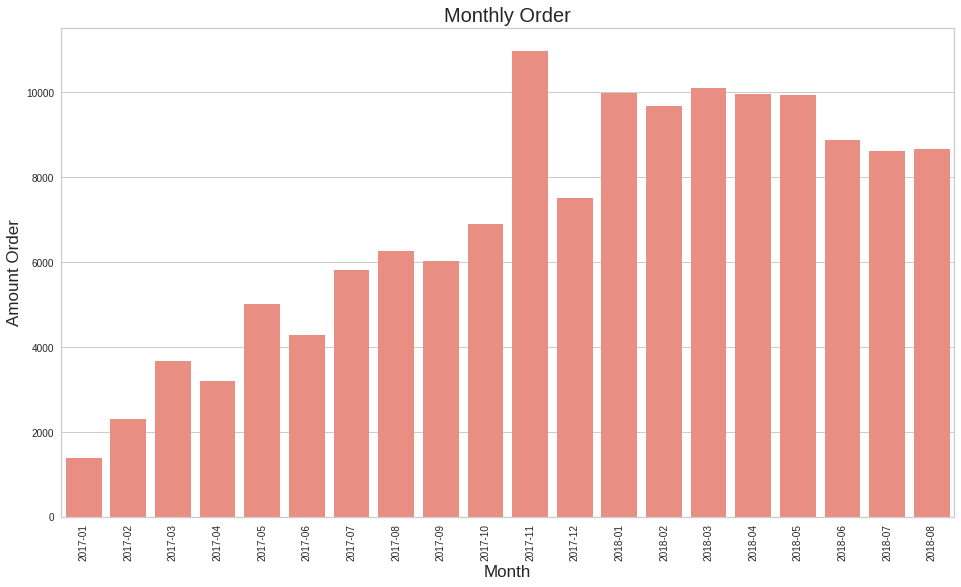

In [47]:
# ¿Cuánto cuesta el pedido cada mes?
order_count_by_month = all_data['order_item_id'].groupby(all_data['Month_order']).sum()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_count_by_month.values, x=order_count_by_month.index, color="Salmon")
plt.title('Monthly Order',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount Order',fontsize=17)

Text(0, 0.5, 'Amount Revenue')

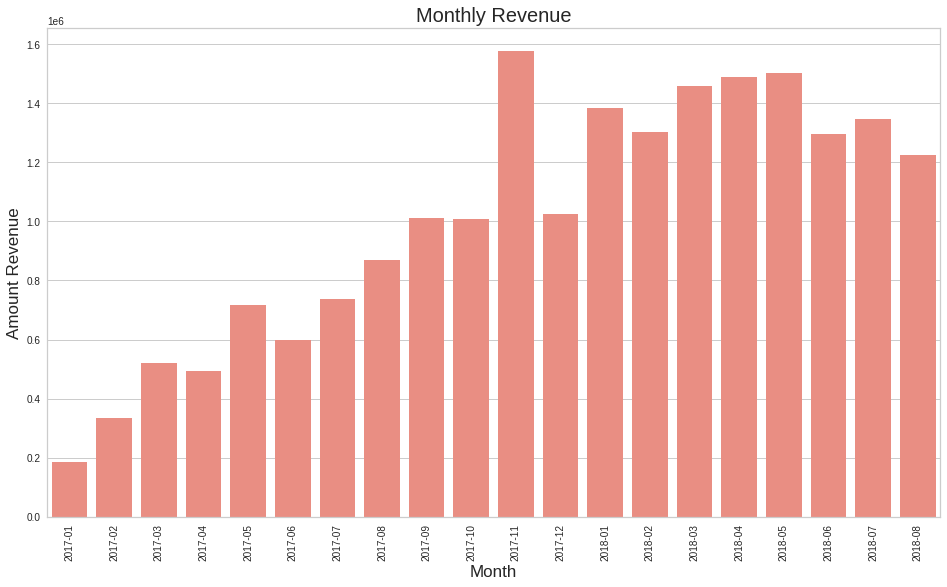

In [48]:
# ¿Cuánto es el ingreso mensual?
revenue_count_by_month = all_data['payment_value'].groupby(all_data['Month_order']).sum()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=revenue_count_by_month.values, x=revenue_count_by_month.index, color="Salmon")
plt.title('Monthly Revenue',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount Revenue',fontsize=17)

Text(0, 0.5, 'Amount of User')

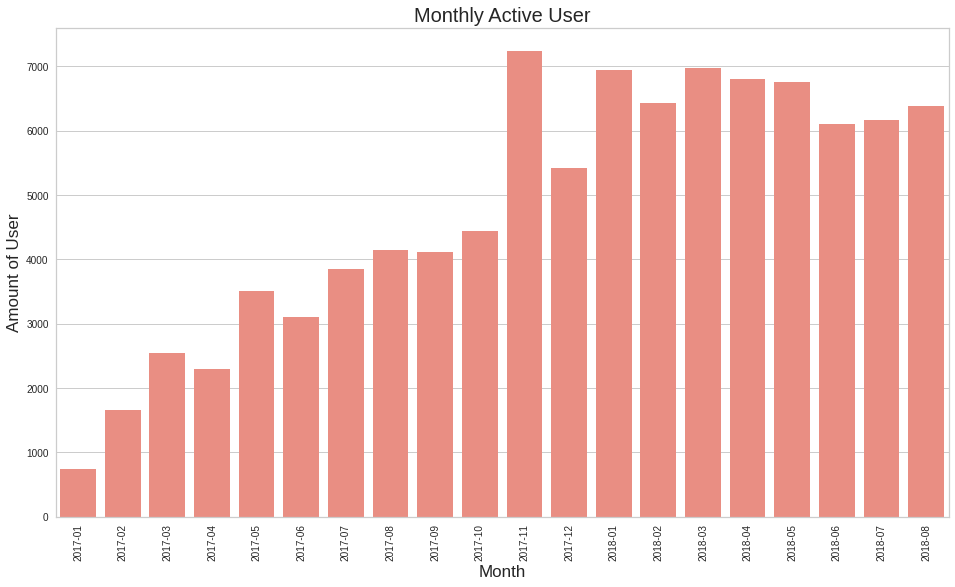

In [49]:
# ¿Cómo son los clientes activos cada mes?
customer_active_by_month = all_data.groupby('Month_order')['customer_unique_id'].nunique().reset_index()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=customer_active_by_month['customer_unique_id'], x=customer_active_by_month['Month_order'], color="Salmon")
plt.title('Monthly Active User',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount of User',fontsize=17)

# ** 3. Modelado **

A partir de esta etapa, deben enfocarse en realizar una segmentación. Se recomienda utilizar el algoritmo de Kmeans para mayor facilidad, pero pueden probar varios. Además pueden investigar sobre qué es un análisis RFM (Recency, Frequency, and Monetary) para la segmentación de clientes, que puede ayudarlos a hacer un KMeans sobre ese análisis. A Modo de indicación, se los comento abajo, pero no es necesario que sigan con ese análisis, pueden realizar el que a uds les parezca.

## ** 3.1 Análisis RFM **

El análisis RFM es un método utilizado para ver patrones en los clientes en función de sus hábitos de compra:

1. Recency = ¿Cuándo fue la última vez que el cliente realizó una transacción?
 
2. Frecuencia = ¿Con qué frecuencia el cliente realiza una compra?

3. Monetario = cuánto gastan los clientes

In [50]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116191 entries, 0 to 116580
Data columns (total 46 columns):
order_id                         116191 non-null object
customer_id                      116191 non-null object
order_status                     116191 non-null object
order_purchase_timestamp         116191 non-null datetime64[ns]
order_approved_at                116191 non-null datetime64[ns]
order_delivered_carrier_date     116191 non-null datetime64[ns]
order_delivered_customer_date    116191 non-null datetime64[ns]
order_estimated_delivery_date    116191 non-null datetime64[ns]
order_item_id                    116191 non-null int64
product_id                       116191 non-null object
seller_id                        116191 non-null object
shipping_limit_date              116191 non-null datetime64[ns]
price                            116191 non-null float64
freight_value                    116191 non-null float64
payment_sequential               116191 non-null int64
p

(array([1.1518e+05, 6.1600e+02, 1.9200e+02, 1.0200e+02, 2.8000e+01,
        2.9000e+01, 2.4000e+01, 1.1000e+01, 6.0000e+00, 3.0000e+00]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <BarContainer object of 10 artists>)

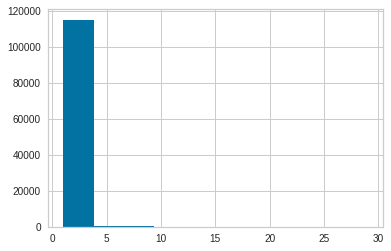

In [51]:
plt.hist(all_data['payment_sequential'])

(array([15009.,     0.,  4119.,     0.,     0.,  9812.,     0., 21961.,
            0., 65290.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

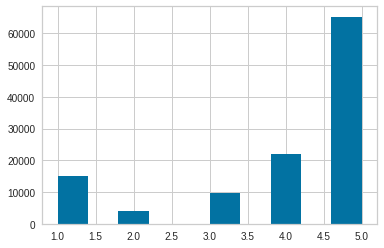

In [52]:
plt.hist(all_data['review_score'])

In [53]:
##Nos quedamos con los días que tardaron, respecto de los que estimaban. 
## Positivo implica cuántos días antes llega de lo que se esperaba, y negativo cuantos días de retraso. 

all_data['order_accuracy_time'] = all_data['order_accuracy_time'].dt.days.astype('int64')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8f40250850>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8f4025a110>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8f402b7d50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8f4025a9d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8f4025ae10>],
 'means': []}

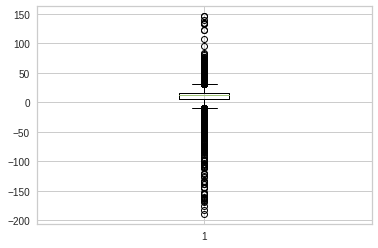

In [54]:
plt.boxplot(all_data['order_accuracy_time'])

In [55]:
all_data['order_accuracy_time'].describe()

count    116191.000000
mean         11.050684
std          10.076673
min        -189.000000
25%           6.000000
50%          12.000000
75%          16.000000
max         146.000000
Name: order_accuracy_time, dtype: float64

In [56]:
##Veamos cuántos datos en promedio hay por encima del tercer cuartil y por debajo del primer cuartil 
print("mayor al segundo cuartil en promedio",
      (sum(all_data['order_accuracy_time']>all_data['order_accuracy_time'].quantile(0.75)))/116191)
print("menor al primer cuartil en promedio",
      (sum(all_data['order_accuracy_time']<all_data['order_accuracy_time'].quantile(0.25)))/116191)

mayor al segundo cuartil en promedio 0.23683417820657365
menor al primer cuartil en promedio 0.20511055073112375


### Vemos que hay demasiados valores fuera de los cuartiles, así que vamos a desestimar la información

In [57]:
##Creamos también la variable que nos dice el tiempo que pasó en días desde la última compra del cliente
Days_from_purchase = (max(all_data['order_purchase_timestamp']))-all_data['order_purchase_timestamp']
Days_from_purchase = Days_from_purchase.dt.days.astype('int64')
all_data['Days_from_purchase'] = Days_from_purchase

In [58]:
### Veamos cual de los dos tiene menos registros, entre 'customer_id' y 'customer_unique_id'
numero = np.unique(all_data['customer_id'])
print ('la cantidad de registros unicos de customer_id es: ',numero.shape)
numero2 = np.unique(all_data['customer_unique_id'])
print ('la cantidad de registros unicos de customer_unique_id es: ',numero2.shape)
##Vemos que 'customer_unique_id' es el ganador, así que vamos a trabajar nuestras varibles sobre el 
Dias_p_cliente = all_data[['customer_unique_id', 'Days_from_purchase']].copy()

mmr =Dias_p_cliente['Days_from_purchase'].groupby(Dias_p_cliente['customer_unique_id']).min()

df= pd.DataFrame(mmr)
df['customer_unique_id']=df.index
df.drop(columns=['customer_unique_id'], inplace=True)
df=df.rename(columns={'Days_from_purchase':'Days_from_last_purchase'}) 
df['Days_from_last_purchase']
            

la cantidad de registros unicos de customer_id es:  (96944,)
la cantidad de registros unicos de customer_unique_id es:  (93790,)


customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    111
0000b849f77a49e4a4ce2b2a4ca5be3f    114
0000f46a3911fa3c0805444483337064    536
0000f6ccb0745a6a4b88665a16c9f078    320
0004aac84e0df4da2b147fca70cf8255    287
                                   ... 
fffcf5a5ff07b0908bd4e2dbc735a684    446
fffea47cd6d3cc0a88bd621562a9d061    261
ffff371b4d645b6ecea244b27531430a    567
ffff5962728ec6157033ef9805bacc48    118
ffffd2657e2aad2907e67c3e9daecbeb    483
Name: Days_from_last_purchase, Length: 93790, dtype: int64

In [59]:
### Armaremos una columna del df que contenga el promedio que gastó cada cliente
mr =all_data['payment_value'].groupby(all_data['customer_unique_id']).mean()
df['mean_payment']=mr
df.head()

,Days_from_last_purchase,mean_payment
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,111,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,27.19
0000f46a3911fa3c0805444483337064,536,86.22
0000f6ccb0745a6a4b88665a16c9f078,320,43.62
0004aac84e0df4da2b147fca70cf8255,287,196.89


In [60]:
## Agregamos una columna de la cantidad de productos comprados en todo el periodo
cant_prod_comp =all_data['order_item_id'].groupby(all_data['customer_unique_id']).sum()
df['cant_prod_comp'] = cant_prod_comp

In [61]:
### Agregamos una columna del volumen promedio del producto adquirido por cliente
vol_prom =all_data['product_volume'].groupby(all_data['customer_unique_id']).mean()
df['product_volume_mean'] = vol_prom

In [62]:
### Agregamos una columna de la cantidad promedio de cuotas en las que compra cada cliente
cant_prom_cuotas =all_data['payment_installments'].groupby(all_data['customer_unique_id']).mean()
df['cant_prom_cuotas'] = cant_prom_cuotas

In [63]:
### Agregamos una columna de la puntuación promedio que le da cada cliente a los vendedor
punt_prom_a_vend =all_data['review_score'].groupby(all_data['customer_unique_id']).mean()
df['punt_prom_a_vend'] = punt_prom_a_vend

In [64]:
### Agregamos una columna del gasto promedio del envio por cliente.
valor_prom_envio =all_data['freight_value'].groupby(all_data['customer_unique_id']).mean()
df['valor_prom_envio'] = valor_prom_envio

In [65]:
df

,Days_from_last_purchase,mean_payment,cant_prod_comp,product_volume_mean,cant_prom_cuotas,punt_prom_a_vend,valor_prom_envio
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,141.90,1,7616.0,8.0,5.0,12.00
0000b849f77a49e4a4ce2b2a4ca5be3f,114,27.19,1,5148.0,1.0,4.0,8.29
0000f46a3911fa3c0805444483337064,536,86.22,1,43750.0,8.0,3.0,17.22
0000f6ccb0745a6a4b88665a16c9f078,320,43.62,1,1045.0,4.0,4.0,17.63
0004aac84e0df4da2b147fca70cf8255,287,196.89,1,528.0,6.0,5.0,16.89
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,2067.42,3,251625.0,10.0,5.0,248.71
fffea47cd6d3cc0a88bd621562a9d061,261,84.58,1,32076.0,1.0,4.0,19.69
ffff371b4d645b6ecea244b27531430a,567,112.46,1,3315.0,1.0,5.0,22.56


# Desde acá empieza el escalado y modelado usando K-means

In [66]:
X = np.array(df[["Days_from_last_purchase", "mean_payment", "cant_prod_comp"]])

In [67]:
## Escalaremos nuestros datos
sc = StandardScaler()
X_std = sc.fit_transform(X)
X_std

array([[-0.82532526, -0.07648343, -0.18677218],
       [-0.80549047, -0.6015851 , -0.18677218],
       [ 1.98460302, -0.33136671, -0.18677218],
       ...,
       [ 2.18956249, -0.2112493 , -0.18677218],
       [-0.77904409, -0.11406589, -0.18677218],
       [ 1.63418843, -0.39847499, -0.18677218]])

In [68]:
### Esta parte tardó como media hora en mi computadora.
#from sklearn.metrics import silhouette_score

#sil = []
#Nc = range(2, 21)
#for k in range(2, 21):
 # kmeans = KMeans(n_clusters = k).fit(X_std)
  #labels = kmeans.labels_
  #sil.append(silhouette_score(X_std, labels, metric = 'euclidean'))

#sil

In [69]:
#plt.plot(Nc,sil)
#plt.xlabel('Cantidad de clusters',color = 'w')
#plt.ylabel('Score',color = 'w')
#plt.title('Silhoutte Curve (Curva silueta)',color='y')
#plt.xticks(Nc,color='g')
#plt.yticks(color='g')
#plt.show()

In [70]:
kmeans = KMeans(n_clusters=5).fit(X_std)
centroids = kmeans.cluster_centers_
print(centroids)

[[-7.25916426e-01 -1.30379508e-01 -7.23127528e-02]
 [ 1.69118833e-02  8.45546569e-01  5.23203302e+00]
 [ 1.89443712e-02  4.23457584e+00  3.46909952e-02]
 [ 9.77863046e-01 -1.36697013e-01 -6.95984275e-02]
 [-9.33271386e-02  3.13016851e+00  4.21994134e+01]]


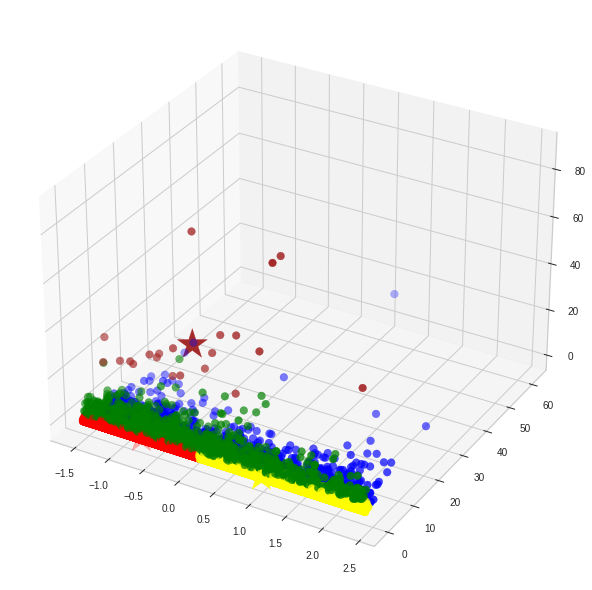

In [71]:
from mpl_toolkits.mplot3d import Axes3D
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X_std)
# Obtenemos los centroids
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow','brown']
clientes=['Cliente_1','Cliente_2','Cliente_3','Cliente_4','Cliente_5']
clasif= []
asignar=[]
for row in labels:
    asignar.append(colores[row])
    clasif.append(clientes[row])
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)
ax.scatter(X_std[:, 0], X_std[:, 1], X_std[:, 2],c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
clasificacion = clasif

# Descripción de los clusters

In [72]:
## Descripción de los centroides
centroides = sc.inverse_transform(centroids)
centroidesdf = pd.DataFrame(centroides, columns = ["Dias_desde_ult_comp", "Gasto_prom", "cant_prod_comp"],
                            index = ['Cliente_1','Cliente_2','Cliente_3','Cliente_4','Cliente_5'])
centroidesdf

,Dias_desde_ult_comp,Gasto_prom,cant_prod_comp
Cliente_1,126.035528,130.126243,1.295758
Cliente_2,238.387873,343.320154,15.001925
Cliente_3,238.695286,1083.663529,1.572250
Cliente_4,383.731171,128.746165,1.302771
Cliente_5,221.714286,842.402511,110.523810


<AxesSubplot:title={'center':'Cantidad en cada cluster'}, ylabel='clasificacion'>

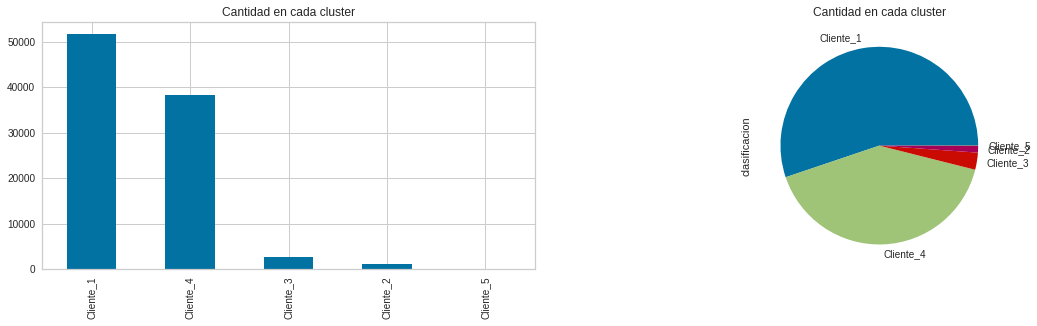

In [73]:
dataframe = pd.DataFrame(X,columns = ["Dias_desde_ult_comp", "Gasto_prom", "cant_prod_comp"])
dataframe['clasificacion']= clasificacion
#dataframe.head(30)
fig = plt.figure(figsize=(30,10))
plt.subplot2grid((2,3),(0,0))
dataframe['clasificacion'].value_counts().plot(kind='bar',title = 'Cantidad en cada cluster')

plt.subplot2grid((2,3),(0,1))
dataframe['clasificacion'].value_counts().plot(kind= 'pie',title = 'Cantidad en cada cluster')

In [74]:
dataframe['clasificacion'].value_counts()

Cliente_1    51755
Cliente_4    38357
Cliente_3     2618
Cliente_2     1039
Cliente_5       21
Name: clasificacion, dtype: int64

# Clientes 1 y 2
### Ambos con un solo producto comprado, y de bajo valor (relativo al resto). Pero la compra del cliente 1 es consideráblemente reciente (cuatro meses contra un año).
### Los más preponderantes en el dataset.


# Cliente 3
### Dos compras en promedio, con último de movimiento ocho meses, pero con un gasto de dinero significativamente mayor al resto de clientes. (compra poco pero productos muy caros)

# Cliente 4
### Último movimiento registrado hace ocho meses, pero compra en promedio 15 artículos. Podríamos considerarlo más frecuente que los anteriores.

# Cliente 5
### Cliente que podríamos catalogarlo como compar al por mayor (respecto del resto). Último movimiento registrado hace alrededor de ocho meses, pero en promedio adquiere gran cantidad de productos.


In [75]:
### Para clasificar un nuevo cliente, deberemos pasarle un array de tres valores
import numpy as np
Dia_desde_ult_comp_NC = float(input('¿Hace cuanto compro el último producto?(en días)')) 
Gasto_prom_NC = float(input('¿Cuánto gastó en promedio?'))
Cant_prod_comp_NC = float(input('¿Cuántos productos compró?'))
Nuevo_cliente = np.array([Dia_desde_ult_comp_NC, Gasto_prom_NC, Cant_prod_comp_NC])
Nuevo_cliente_Std = sc.transform([Nuevo_cliente])
labels_NC = kmeans.predict(Nuevo_cliente_Std)
if labels_NC == 0: print ('El nuevo cliente es de tipo 1')
elif labels_NC == 1: print ('El nuevo cliente es de tipo 2')
elif labels_NC == 2: print ('El nuevo cliente es de tipo 3')
elif labels_NC == 3: print ('El nuevo cliente es de tipo 4')
elif labels_NC == 4: print ('El nuevo cliente es de tipo 5')

¿Hace cuanto compro el último producto?(en días)345
¿Cuánto gastó en promedio?345
¿Cuántos productos compró?3
El nuevo cliente es de tipo 4


In [122]:
### Acá calculamos las medias y desvíos estandar para usarlos en el modelo en producción
### Esos arrays deberíamos sacarlos en un csv (algo así entendí)

means = np.array((X[:,0].mean(), X[:,1].mean(),X[:,2].mean()))
stds = np.array ((X[:,0].std(), X[:,1].std(),X[:,2].std()))

### Estas dos serían las que escalan el nuevo cliente
casiZ = np.array(Nuevo_cliente-means)
Nuevo_cliente_estand = np.array([casiZ[0]/stds[0],casiZ[1]/stds[1],casiZ[2]/stds[2]],ndmin=2)
print (Nuevo_cliente_Std)
print (Nuevo_cliente_estand)

[[0.72178819 0.85323631 0.58723643]]
[[0.72178819 0.85323631 0.58723643]]


In [120]:
labels_NC = kmeans.predict(Nuevo_cliente_estand)
if labels_NC == 0: print ('El nuevo cliente es de tipo 1')
elif labels_NC == 1: print ('El nuevo cliente es de tipo 2')
elif labels_NC == 2: print ('El nuevo cliente es de tipo 3')
elif labels_NC == 3: print ('El nuevo cliente es de tipo 4')
elif labels_NC == 4: print ('El nuevo cliente es de tipo 5')

El nuevo cliente es de tipo 4
